In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional, Conv1D
from tensorflow.keras.layers import Dropout
import nltk
import re
from nltk.corpus import stopwords

In [2]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.2.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df = pd.read_csv("CVAssignmentDataset.csv")

In [4]:
df

,Class,Text
0,1,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,1,RT @WinterHavenSun: Winter Haven resident / Al...
2,1,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,1,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,1,RT @Vegalteno: Hurricane season starts on June...
...,...,...
86456,0,Check out my op-ed on need for End Executive O...
86457,0,"Yesterday, Betty &amp; I had a great time lear..."
86458,0,We are forever grateful for the service and sa...
86459,0,Happy first day of school @CobbSchools! #CobbB...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86461 entries, 0 to 86460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   86461 non-null  object
 1   Text    86460 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [6]:
df=df.dropna()
df['Num_words'] = df['Text'].apply(lambda x:len(str(x).split()))
mask = df['Num_words'] >2
df = df[mask]

/home/asingh/anaconda3/envs/interncv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df

,Class,Text,Num_words
0,0,Joining @1450whtc LIVE now for a morning Q&amp...,12
1,0,.@HurdOnTheHill: And for that sacrifice we sho...,20
2,0,Tell us what YOU think Congress should do to r...,16
3,1,Before becoming the first African-American wom...,18
4,0,After introducing the POST Act (#HR5524) to en...,19
...,...,...,...
85852,1,#BigPharma must be held accountable for the de...,17
85853,0,As co-chair of the House Adult Literacy Caucus...,23
85854,0,"To avoid another government shutdown, the Hous...",21
85855,1,RT @repjoecrowley: Welcome to the newest membe...,23


<AxesSubplot:xlabel='Class', ylabel='count'>

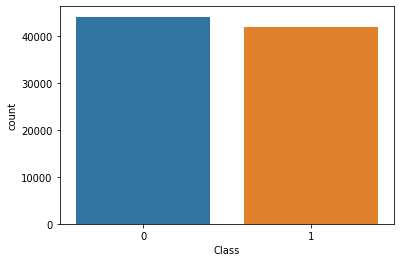

In [9]:
sns.countplot(x= 'Class',data = df)

In [11]:
df.Class.value_counts()

0    44064
1    41793
Name: Class, dtype: int64

In [22]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)



def clean_text(text ):
    text = text.lower()
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if (not w.isdigit() and len(w)>2 and not w in stopwords.words('english'))]) 
    
    return text2

In [23]:
df.Text = df.Text.apply(remove_emoji)
df.Text = df.Text.apply(remove_url)
df.Text = df.Text.apply(clean_text)

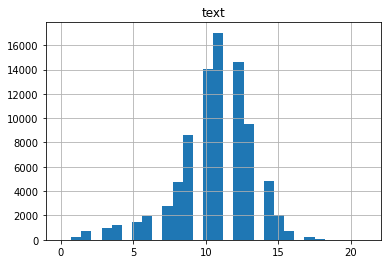

In [24]:
text_word_count = []
# populate the lists with sentence lengths
for i in df.Text:
      text_word_count.append(len(i.split()))
length_df = pd.DataFrame({'text':text_word_count})
length_df.hist(bins = 30)
plt.show()

In [25]:
cnt=0
for i in df.Text:
    if(len(i.split())<=50):
        cnt=cnt+1
print(cnt/len(df.Text))

1.0


In [26]:
df_train = df.sample(frac = 0.8) 
df_test = df.drop(df_train.index) 
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [27]:
x,y = df_train.Text,df_train.Class

In [28]:
x

0        congress fight fbi access information entitled...
1        drphilroe thank kind words johnny appreciate w...
2        privilege welcome wwii korean war veterans mic...
3        sit transport transportdems last summer commit...
4                        congratulations justicestras mn02
                               ...                        
68681    thank coalition partners coming capitol prepar...
68682    honored meet drlobsangsangay president central...
68683    afternoon committee meet amp concealed carry r...
68684    morning subcommittee heard testimony giancarlo...
68685               busy week ahead house take look voting
Name: Text, Length: 68686, dtype: object

In [29]:
num_words = 10000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(x.tolist())

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, random_state=0)

In [31]:
x_train = np.array(tokenizer.texts_to_sequences(X_train))
x_valid = np.array(tokenizer.texts_to_sequences(X_valid))
x_test  = np.array(tokenizer.texts_to_sequences(df_test['Text'].tolist()))

/home/asingh/anaconda3/envs/interncv/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/home/asingh/anaconda3/envs/interncv/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/home/asingh/anaconda3/envs/interncv/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different

In [32]:
x_train = pad_sequences(x_train, padding='post', maxlen=50)
x_valid = pad_sequences(x_valid, padding='post', maxlen=50)
x_test = pad_sequences(x_test, padding='post', maxlen=50)

In [33]:
x_train[0],x_valid[0],x_test[0]

(array([  17,  970,  220,  155, 1645, 4752,    1,    1,  458,    1,   13,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0], dtype=int32),
 array([  39,  971,  260,  859, 1248,   13,  684, 2243, 3264,  251,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0], dtype=int32),
 array([ 177,    1,   43,   40, 3630,   92,  986,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 